# 說明
- 參考文章：[https://github.com/ypwhs/dogs_vs_cats](https://github.com/ypwhs/dogs_vs_cats)

In [1]:
import os

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
file_path = []
category = []

for d in ['cats', 'dogs']:
    dir_path = 'data/train/' + d
    for file in os.listdir(dir_path):
        file_path.append(dir_path+ '/' + file)
        category.append(file.split('.')[0])

df_train = pd.DataFrame({'file_path': file_path, 'category': category})

df_test = pd.DataFrame({'file_path': os.listdir('data/test')})
df_test['file_path'] = df_test['file_path'].apply(lambda s: 'data/test/'+s)

# train, valid = train_test_split(df_train, test_size=0.2)

In [ ]:

"""    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       channel_shift_range=10,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    valid_datagen = ImageDataGenerator(rescale=1./255)"""


In [58]:
def write_gap(MODEL, model_name, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    train_datagen = ImageDataGenerator()
    valid_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_dataframe(df_train,
                                                        x_col='file_path', 
                                                        y_col='category',
                                                        target_size=image_size,
                                                        interpolation='bicubic',
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        batch_size=16)

    test_generator = valid_datagen.flow_from_dataframe(df_test, 
                                                       x_col='file_path', 
                                                        target_size=image_size, 
                                                        batch_size=16,
                                                        class_mode=None, 
                                                        shuffle=False)

    train = model.predict_generator(train_generator, verbose=1, steps=len(train_generator))
    test = model.predict_generator(test_generator, verbose=1, steps=len(test_generator))
    with h5py.File("gap_%s.h5"%model_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

write_gap(ResNet50, 'ResNet50', (224, 224))
write_gap(InceptionV3, 'InceptionV3', (299, 299), inception_v3.preprocess_input)
write_gap(Xception, 'Xception', (299, 299), xception.preprocess_input)

Found 4000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames.
25/25 [==============================] - 3s 107ms/step
Found 4000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames.
25/25 [==============================] - 3s 130ms/step
Found 4000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames.
25/25 [==============================] - 6s 224ms/step


In [59]:
X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [60]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [87]:
digraph G{
    node [shape=record]
    a[label="ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}"]
    b[label="InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}"]
    c[label="Xception|{input:|output:}|{(299, 299, 3)|(2048)}"]
    Merge[label="Merge|{input:|output:}|{(3, 2048)|(6144)}"]
    Dropout[label="Dropout|Rate:|0.5"]
    Output[label="Output|{input:|output:}|{(6144)|(1)}"]
    Image -> a -> Merge
    Image -> b -> Merge
    Image -> c -> Merge
    Merge -> Dropout -> Output
}

SyntaxError: invalid syntax (<ipython-input-87-bad78206b41c>, line 1)

In [61]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

C:\Users\benja\Anaconda3\envs\ml_100_days\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3200 samples, validate on 800 samples
Epoch 1/8
3200/3200 [==============================] - 16s 5ms/step - loss: 0.2825 - acc: 0.8925 - val_loss: 0.0910 - val_acc: 0.9900
Epoch 2/8
3200/3200 [==============================] - 0s 130us/step - loss: 0.0840 - acc: 0.9819 - val_loss: 0.0574 - val_acc: 0.9912
Epoch 3/8
3200/3200 [==============================] - 0s 133us/step - loss: 0.0528 - acc: 0.9897 - val_loss: 0.0381 - val_acc: 0.9938
Epoch 4/8
3200/3200 [==============================] - 0s 141us/step - loss: 0.0399 - acc: 0.9909 - val_loss: 0.0292 - val_acc: 0.9950
Epoch 5/8
3200/3200 [==============================] - 0s 129us/step - loss: 0.0290 - acc: 0.9928 - val_loss: 0.0248 - val_acc: 0.9925
Epoch 6/8
3200/3200 [==============================] - 0s 142us/step - loss: 0.0260 - acc: 0.9937 - val_loss: 0.0221 - val_acc: 0.9925
Epoch 7/8
3200/3200 [==============================] - 0s 135us/step - loss: 0.0204 - acc: 0.9934 - val_loss: 0.0250 - val_acc: 0.9925
Epoch 8/8

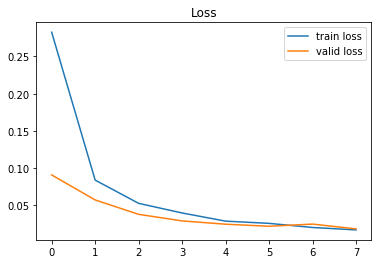

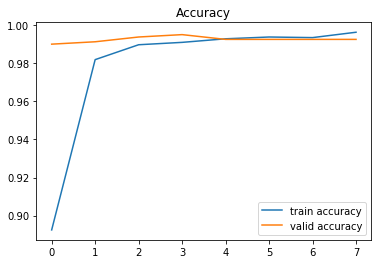

In [62]:
# 檢視訓練過程

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [78]:
# 預測test data
y_pred = model.predict(X_test, verbose=1)
# y_pred = y_pred.clip(min=0.005, max=0.995)

400/400 [==============================] - 0s 871us/step


In [80]:
pic_id = df_test['file_path'].apply(lambda s: s[10:13])
solution = pd.DataFrame({"ID": pic_id, "Predicted":y_pred[:,0]})

solution.head()

,ID,Predicted
0,000,0.048424
1,001,0.092810
2,002,0.000585
3,003,0.999194
4,004,0.000241


In [81]:
solution.to_csv('submission_3models_0819.csv', index=False)